# Chai Project Parts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px

In [2]:
df = pd.read_csv('responses.csv')

df = df.iloc[:, 74:76]
df = df.rename(columns={'74. How many hours do you play video games in an average week? (PC, console, phone...)': 'HourPlayed', '75. How many hours do you spend watching gaming streams in a week?': 'HourWatched'})
df.iloc[:, 0:2] = df.iloc[:, 0:2].replace(to_replace=r'[^\d.]+', value='', regex=True)
df.iloc[:, 0:2] = df.iloc[:, 0:2].replace(to_replace='', value=0)
df.iloc[:, 0:2] = df.iloc[:, 0:2].replace(np.nan, 0)
df.iloc[:, 2:3] = df.iloc[:, 2:3].fillna('None')

# df = df.loc[:, '74. How many hours do you play video games in an average week? (PC, console, phone...)':'77. What is the name of the game you play most?']
# df.loc[:, '74. How many hours do you play video games in an average week? (PC, console, phone...)':'75. How many hours do you spend watching gaming streams in a week?'] = df.loc[:, '74. How many hours do you play video games in an average week? (PC, console, phone...)':'75. How many hours do you spend watching gaming streams in a week?'].replace(to_replace=r'[^\d.]+', value='', regex=True)
# df.loc[:, '74. How many hours do you play video games in an average week? (PC, console, phone...)':'75. How many hours do you spend watching gaming streams in a week?'] = df.loc[:, '74. How many hours do you play video games in an average week? (PC, console, phone...)':'75. How many hours do you spend watching gaming streams in a week?'].replace(np.nan, 0)

df.head(5)

,HourPlayed,HourWatched
0,15,10
1,0,0
2,20,0
3,20,8
4,0,0


**Average Time Spent Playing and Watching Video Game Streams per week**

In [3]:
df = df.iloc[:, 0:2]

df['HourPlayed'] = df['HourPlayed'].astype(float)
df['HourWatched'] = df['HourWatched'].astype(float)
avg = df[['HourPlayed', 'HourWatched']].mean()

avg

HourPlayed     7.354545
HourWatched    1.454545
dtype: float64

Here, we note that the average time spent playing video games is nearly 4x the time spent watching video game streams.

<AxesSubplot:>

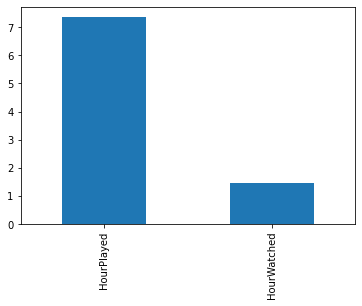

In [4]:
avg.plot.bar()

However, it's important to note that this information considers **all** responses, even those where students put 0 for both `HourWatched` and `HourPlayed` as evident below.  Let's look at the average when we drop those values!

In [5]:
df.head(5)

,HourPlayed,HourWatched
0,15.0,10.0
1,0.0,0.0
2,20.0,0.0
3,20.0,8.0
4,0.0,0.0


Drop our values by seeing if all rows are equal to 0 (We are only looking at `HoursWatched` and `HoursPlayed`).  Why exactly are we dropping this?  Since we are trying to find the correlation of whether playing video games leads to watching video games, it becomes redudant to have information when a student does **neither** of the things.  Without dropping our zero values, there is correlation without stipulation.

In [6]:
df = df.loc[~(df==0).all(axis=1)]

df.head(5)

,HourPlayed,HourWatched
0,15.0,10.0
2,20.0,0.0
3,20.0,8.0
7,3.0,0.0
9,5.0,0.0


In [7]:
avg = df[['HourPlayed', 'HourWatched']].mean()

avg

HourPlayed     11.557143
HourWatched     2.285714
dtype: float64

<AxesSubplot:>

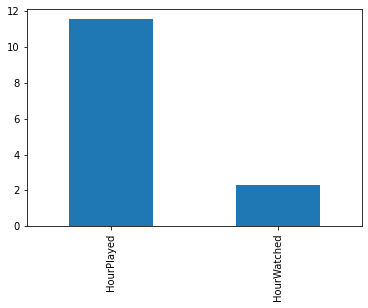

In [8]:
avg.plot.bar()

## Conducting Correlation Between Hours spent Watching Streams and Hours Spent Playing Games

In [10]:
corr1 = df['HourWatched']
corr2 = df['HourPlayed']

print("Correlation Coefficient:",corr2.corr(corr1))

Correlation Coefficient: 0.3453903224064976


<AxesSubplot:>

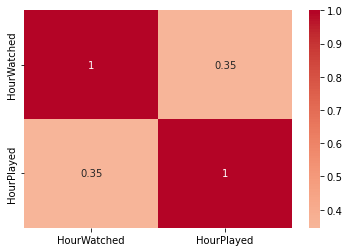

In [11]:
import seaborn as sns

hours_correlation = df[['HourWatched', 'HourPlayed']].corr()

sns.heatmap(hours_correlation, center=0, cmap="coolwarm", annot=True)

So, with a correlation coefficient of `0.345`, we can see that there is some positive correlation (albeit low) between Hours spent watching Streams versus Hours spent playing Games.  At this point, there is nearly a neglible correlation between the two, but we can save that for until we do our Chi-Squared Test on our Data

**Conducting Chi-Squared Test on Data**

The chi-squared test is a hypothesis test used to determine whether there is any significant association between two catergorical variables in the data.  In our case, we would like to see if there is any significance between `HourWatched` and `HourPlayed`.  Before we can proceed into testing, we must first develop our two hypothesis:

* H0: There is **no relationship** between the two variables, and our data is independent
* H1: There **is a relationship** between the two variables, and our data is dependent on the other.


Before we begin, we need to create a smaller subset of data that disregards NaNs and only pays attention to those variables.  After that, we calculate the row and column totals for each

In [12]:
observed = df.copy()
observed

,HourPlayed,HourWatched
0,15.0,10.0
2,20.0,0.0
3,20.0,8.0
7,3.0,0.0
9,5.0,0.0
...,...,...
104,10.0,0.0
106,5.0,0.0
107,30.0,4.0
108,28.0,2.0


In [13]:
hours_count = observed.copy()
hours_count.loc['col_total'] = hours_count.sum(axis=0)
hours_count['row_total'] = hours_count.sum(axis=1)
hours_count

,HourPlayed,HourWatched,row_total
0,15.0,10.0,25.0
2,20.0,0.0,20.0
3,20.0,8.0,28.0
7,3.0,0.0,3.0
9,5.0,0.0,5.0
...,...,...,...
106,5.0,0.0,5.0
107,30.0,4.0,34.0
108,28.0,2.0,30.0
109,20.0,1.0,21.0


In order to create our expected table, we need to multiply the row total to the colum total and divide by the total number of observations for a cell to get our expected count.  We can do this utilizing the `np.outer()` function in order to get those totals.  Then, we can divide the outputs by the true total, which in this case is `969`.

In [14]:
expected = np.outer(hours_count["row_total"][0:70], hours_count.loc["col_total"][0:2]) / 969

expected = pd.DataFrame(expected)

expected.columns = ['HourPlayed', 'HourWatched']

expected

,HourPlayed,HourWatched
0,20.872033,4.127967
1,16.697626,3.302374
2,23.376677,4.623323
3,2.504644,0.495356
4,4.174407,0.825593
...,...,...
65,8.348813,1.651187
66,4.174407,0.825593
67,28.385965,5.614035
68,25.046440,4.953560


**Creating Chi-Squared Statistic**

After calculating our expected table, we can then calculate the chi-square static value with the below formula.

In [16]:
chi_squared_stat = (((observed - expected)**2) / expected).sum().sum()
print("Chi-Squared static value:",chi_squared_stat)

Chi-Squared static value: 2166.033316451384


Then, after importing `chi2` from the `scipy.stats` library, we can figure out our critical values and p-values.  In the case of our experiment, we are utilizing a Confidence Rate of 99.9%.  Our table is currently 70 x 2, therefore our degrees of freedom will be 69 (as 69 x 1).

In [17]:
from scipy.stats import chi2

critical_value = chi2.ppf(q=0.999, df=69)
print("Critical Value:",critical_value)

p_value = 1 - (chi2.cdf(x=chi_squared_stat, df=69))
print("P Value:", p_value)

Critical Value: 111.05506556267146
P Value: 0.0


Based on the heatmap, we already knew that there is a low positive correlation between the hours spent watching versus the hour spent playing video games.  However, a correlation near 30% is subject to potentially being negligible!  Since our p-value of 0.00 is less than the required threshold of 0.001, we can reject the null hypothesis and claim that there is some correlation between Hours Spent Watching Video Games and Hours Spent Playing Video Games